# LPFormer: An Adaptive Graph Transformer for Link Prediction

This notebook implements the LPFormer model as described in the paper "LPFormer: An Adaptive Graph Transformer for Link Prediction" (Shomer et al., 2024), applied to the Marvel Universe dataset. The implementation includes components described in the paper:

1. GCN-based node representation learning
2. PPR-based relative positional encodings with order invariance
3. GATv2 attention mechanism for adaptive pairwise encoding
4. Efficient node selection via PPR thresholding using Andersen's algorithm
5. Proper evaluation metrics as specified in the paper
6. LP factor analysis for performance evaluation

The implementation is optimized for GPU execution.

## 1. Setup and Dependencies

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html
!pip install torch-geometric
!pip install numpy pandas scipy matplotlib networkx tqdm scikit-learn
!pip install ipywidgets --upgrade
!pip show ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Name: ipywidgets
Version: 8.1.7
Summary: Jupyter interactive widgets
Home-page: http://jupyter.org
Author: Jupyter Development Team
Author-email: jupyter@googlegroups.com
License: BSD 3-Clause License
Location: /storage/homefs/fn24z071/.local/lib/python3.11/site-packages
Requires: comm, ipython, jupyterlab_widgets, traitlets, widgetsnbextension
Required-by: jupyter


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GATv2Conv
from torch_geometric.utils import to_undirected, add_self_loops, degree
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.loader import DataLoader
import scipy.sparse as sp
from scipy.sparse.linalg import norm as sparse_norm
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import tqdm
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import time
from matplotlib.patches import Patch

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/storage/homefs/fn24z071/.local/lib/python3.11/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /storage/homefs/fn24z071/.local/lib/python3.11/site-packages/libpyg.so: undefined symbol: _ZN2at4_ops10zeros_like4callERKNS_6TensorEN3c108optionalINS5_10ScalarTypeEEENS6_INS5_6LayoutEEENS6_INS5_6DeviceEEENS6_IbEENS6_INS5_12MemoryFormatEEE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/storage/homefs/fn24z071/.local/lib/python3.11/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /storage/homefs/fn24z071/.local/lib/python3.11/site-packages/libpyg.so: undefined symbol: _ZN2at4_ops10zeros_like4callERKNS_6TensorEN3c108optionalINS5_10ScalarTypeEEENS6_INS5_6LayoutEEENS6_INS5_6DeviceEEENS6_IbEENS6_INS5_12MemoryFormatEEE
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


Using device: cuda


## 2. Marvel Dataset Loading and Processing

We load and process the Marvel Universe dataset, which consists of connections between heroes and comics.

In [3]:
print("Loading Marvel dataset...")
start_time = time.time()

edges_df = pd.read_csv('edges_corr.csv')
nodes_df = pd.read_csv('nodes_corr.csv')

print(f"Dataset loaded in {time.time() - start_time:.2f} seconds")
print(f"Edges shape: {edges_df.shape}")
print(f"Nodes shape: {nodes_df.shape}")

# Display first few rows of each dataset
print("\nEdges preview:")
display(edges_df.head())

print("\nNodes preview:")
display(nodes_df.head())

# Check for missing values
print("\nMissing values in edges:", edges_df.isnull().sum().sum())
print("Missing values in nodes:", nodes_df.isnull().sum().sum())

print("\nUnique heroes:", edges_df['hero'].nunique())
print("Unique comics:", edges_df['comic'].nunique())
print("Node types:", nodes_df['type'].unique())
print("Node type counts:")
display(nodes_df['type'].value_counts())

Loading Marvel dataset...
Dataset loaded in 0.07 seconds
Edges shape: (96104, 2)
Nodes shape: (19090, 2)

Edges preview:


,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251



Nodes preview:


,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero



Missing values in edges: 0
Missing values in nodes: 0

Unique heroes: 6439
Unique comics: 12651
Node types: ['comic' 'hero']
Node type counts:


type
comic    12651
hero      6439
Name: count, dtype: int64

In [4]:
print("Processing Marvel dataset...")
start_time = time.time()

node_encoder = LabelEncoder()
nodes_df['node_idx'] = node_encoder.fit_transform(nodes_df['node'])

node_to_idx = {node: idx for node, idx in zip(nodes_df['node'], nodes_df['node_idx'])}
idx_to_node = {idx: node for node, idx in node_to_idx.items()}

edges_df['hero_idx'] = edges_df['hero'].map(node_to_idx)
edges_df['comic_idx'] = edges_df['comic'].map(node_to_idx)

# Check for mapping failures
missing_heroes = edges_df[edges_df['hero'].map(lambda x: x not in node_to_idx)]
missing_comics = edges_df[edges_df['comic'].map(lambda x: x not in node_to_idx)]

if len(missing_heroes) > 0 or len(missing_comics) > 0:
    print(f"Warning: Found {len(missing_heroes)} heroes and {len(missing_comics)} comics missing from nodes_df")
    # Filter out edges with missing nodes
    edges_df = edges_df[edges_df['hero'].map(lambda x: x in node_to_idx) &
                        edges_df['comic'].map(lambda x: x in node_to_idx)]
    
    edges_df['hero_idx'] = edges_df['hero'].map(node_to_idx)
    edges_df['comic_idx'] = edges_df['comic'].map(node_to_idx)

edge_index = torch.tensor([edges_df['hero_idx'].values.astype(np.int64),
                          edges_df['comic_idx'].values.astype(np.int64)], dtype=torch.long)

# Make the graph undirected for link prediction
edge_index = to_undirected(edge_index)

nodes_df['type_idx'] = nodes_df['type'].map({'hero': 0, 'comic': 1})
node_types = torch.tensor(nodes_df['type_idx'].values, dtype=torch.long)

# Create node features
# 1. One-hot encoding ensures later no link prediction hero-hero
type_features = F.one_hot(node_types, num_classes=2).float()

# 2. Add degree features (normalized)
row, col = edge_index
deg = degree(row, nodes_df.shape[0])
deg_normalized = deg / deg.max()
deg_features = deg_normalized.unsqueeze(1)

node_features = torch.cat([type_features, deg_features], dim=1)

data = Data(x=node_features, edge_index=edge_index)
data.num_nodes = nodes_df.shape[0]

print(f"Node feature shape: {node_features.shape}")
print(f"Edge index shape: {edge_index.shape}")
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.edge_index.size(1)}")

print(f"Dataset processing completed in {time.time() - start_time:.2f} seconds")

Processing Marvel dataset...
Node feature shape: torch.Size([19090, 3])
Edge index shape: torch.Size([2, 191654])
Number of nodes: 19090
Number of edges: 191654
Dataset processing completed in 0.44 seconds


### 2.1 Subgraph

In [5]:
start_time_project = time.time()

def get_smaller_graph(edge_index, nodes_df, core_ratio=0.1, hops=2, max_ratio=0.3):
    
    print(f"\nStarting graph")
    print("(Might take a sec)")
    
    node_count = nodes_df.shape[0] 
    connections_total = edge_index.shape[1] // 2  # Because undirected
    target_node_count = int(node_count * max_ratio)
    base_nodes = max(100, min(int(node_count * core_ratio), 1000))  # At least 100
    
    print(f"\nOriginal:")
    print(f"- Nodes: {node_count}")
    print(f"- Edges: {connections_total}")
    print(f"- Avg friends: {edge_index.shape[1]/node_count:.1f}")
    print(f"\nTrying to get:")
    print(f"- Start with {base_nodes} base nodes")
    print(f"- Max {target_node_count} nodes total")
    print(f"- Looking {hops} steps out")

    neighbors = {} 
    edge_pairs = set()  # For checking later
    
    for col in range(edge_index.shape[1]):
        node_a = edge_index[0, col].item()
        node_b = edge_index[1, col].item()
        
        if node_a not in neighbors:
            neighbors[node_a] = set()
        if node_b not in neighbors:
            neighbors[node_b] = set()
            
        neighbors[node_a].add(node_b)
        neighbors[node_b].add(node_a)  # Undirected
        
        # Keep unique pairs
        if node_a < node_b:
            edge_pairs.add( (node_a, node_b) )
        else:
            edge_pairs.add( (node_b, node_a) )

    node_scores = [ (n, len(neighbors[n])) for n in neighbors ]
    node_scores.sort(key=lambda x: -x[1])  # Sort descending

    heroes = []
    comics = []
    for n, score in node_scores:
        if n >= len(nodes_df):  # Skip invalid ones
            continue
        if nodes_df.iloc[n]['type'] == 'hero':
            heroes.append( (n, score) )
        else:
            comics.append( (n, score) )

    # Pick starting points - half heroes, half comics
    num_hero_starts = min(len(heroes), base_nodes//2)
    num_comic_starts = min(len(comics), base_nodes//2)
    
    start_nodes = [n for n,_ in heroes[:num_hero_starts]]
    start_nodes += [n for n,_ in comics[:num_comic_starts]]
    current_nodes = set(start_nodes)
    all_selected = set(start_nodes)

    # Expand in waves
    for step in range(hops):
        if len(all_selected) >= target_node_count:
            print("Too big! Stopping early")
            break
        
        new_nodes = set()
        added = 0
        
        # Look at each node's friends
        for node in current_nodes:
            if node not in neighbors:  # Just in case
                continue
                
            for friend in neighbors[node]:
                if friend not in all_selected:
                    if len(all_selected) < target_node_count:
                        new_nodes.add(friend)
                        all_selected.add(friend)
                        added += 1
                    else:
                        break  # Stop if full
                        
            if len(all_selected) >= target_node_count:
                break  
                
        current_nodes = new_nodes
        
        if not new_nodes:
            print("No more neighbors")
            break

    final_nodes = sorted(list(all_selected))
    print(f"\nDone! Got {len(final_nodes)} nodes")
    print(f"({len(final_nodes)/node_count:.1%} of original)")

    # Check balance
    hero_count = 0
    for n in final_nodes:
        if n < len(nodes_df) and nodes_df.iloc[n]['type'] == 'hero':
            hero_count +=1
    print(f"- Heroes: {hero_count}, Comics: {len(final_nodes)-hero_count}")

    id_map = {old:new for new,old in enumerate(final_nodes)}
    
    new_edges = []
    kept = 0
    lost = 0
    
    for a,b in edge_pairs:
        if a in id_map and b in id_map:
            new_a = id_map[a]
            new_b = id_map[b]
            new_edges.append([new_a, new_b])
            new_edges.append([new_b, new_a])  # Undirected
            kept +=1
        else:
            lost +=1

    if not new_edges:
        print("Yikes, no edges left!")
        return [], torch.tensor([])
    
    edge_matrix = torch.tensor(new_edges, dtype=torch.long).t()

    if kept > 0:
        avg_degree = sum(len(neighbors[n]) for n in final_nodes)/len(final_nodes)
        print(f"\nNew graph stats:")
        print(f"- Avg connections: {avg_degree:.1f}")
        print(f"- Kept {kept/(connections_total):.1%} edges")

    return final_nodes, edge_matrix

#### 2.1.1 Subgraph settings

In [6]:
# Try it out with these settings
selected_nodes, new_edges = get_smaller_graph(
    data.edge_index, nodes_df,
    core_ratio=0.1,  
    hops=50,          
    max_ratio=0.3
)

if selected_nodes:
    remapping = {old:new for new,old in enumerate(selected_nodes)}
    
    small_features = data.x[selected_nodes]
    
    compact_data = Data(x=small_features, edge_index=new_edges)
    compact_data.num_nodes = len(selected_nodes)
    
    old_count = len(nodes_df)
    new_nodes_df = nodes_df[nodes_df['node_idx'].isin(selected_nodes)].copy()
    new_nodes_df['new_id'] = new_nodes_df['node_idx'].map(remapping)
    print(f"Trimmed from {old_count} to {len(new_nodes_df)} nodes")
    
    print(f"\n\n ---")
    print(f"Original: {data.num_nodes} nodes, {data.edge_index.size(1)//2} edges")
    print(f"New:      {compact_data.num_nodes} nodes, {compact_data.edge_index.size(1)//2} edges")
    print(f"({compact_data.num_nodes/data.num_nodes:.1%} nodes kept)")
    
    data = compact_data
    
    # Fix the dataframe columns
    new_nodes_df['node_idx'] = new_nodes_df['new_id']
    new_nodes_df = new_nodes_df.drop('new_id', axis=1)
    nodes_df = new_nodes_df.reset_index(drop=True)
    
    print(f"\nDone in {time.time()-start_time:.2f}s!")
else:
    print("Failed... using original graph")

node_to_idx = {row['node']:row['node_idx'] for _,row in nodes_df.iterrows()}
idx_to_node = {v:k for k,v in node_to_idx.items()}
print(f"Updated mappings for {len(node_to_idx)} nodes")


Starting graph
(Might take a sec)

Original:
- Nodes: 19090
- Edges: 95827
- Avg friends: 10.0

Trying to get:
- Start with 1000 base nodes
- Max 5727 nodes total
- Looking 50 steps out
Too big! Stopping early

Done! Got 5727 nodes
(30.0% of original)
- Heroes: 950, Comics: 4777

New graph stats:
- Avg connections: 21.5
- Kept 42.8% edges
Trimmed from 19090 to 5727 nodes


 ---
Original: 19090 nodes, 95827 edges
New:      5727 nodes, 40975 edges
(30.0% nodes kept)

Done in 1.92s!
Updated mappings for 5727 nodes


### 2.2 Creating train/validation/test splits

In [7]:
print("CREATING TRAIN/VALIDATION/TEST SPLITS")
start_time = time.time()

transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    is_undirected=True,
    add_negative_train_samples=True,
    neg_sampling_ratio=1.0
)

train_data, val_data, test_data = transform(data)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

node_type_map = dict(zip(nodes_df['node_idx'], nodes_df['type']))
hero_indices = nodes_df[nodes_df['type'] == 'hero']['node_idx'].values
comic_indices = nodes_df[nodes_df['type'] == 'comic']['node_idx'].values

def create_bipartite_negatives(pos_edges, neg_edges, hero_indices, comic_indices, 
                               node_type_map, split_name=""):
    
    print(f"\nProcessing {split_name} split:")
    
    valid_negatives = []
    
    for i in range(neg_edges.size(0)):
        src, dst = neg_edges[i][0].item(), neg_edges[i][1].item()
        
        if src in node_type_map and dst in node_type_map:
            if node_type_map[src] != node_type_map[dst]:
                valid_negatives.append([src, dst])
    
    filtered_neg_tensor = torch.tensor(valid_negatives, device=neg_edges.device, dtype=neg_edges.dtype) if valid_negatives else torch.zeros((0, 2), device=neg_edges.device, dtype=neg_edges.dtype)
    
    print(f"  Filtered negatives: {neg_edges.size(0)} → {len(valid_negatives)} (removed {neg_edges.size(0) - len(valid_negatives)} same-type pairs)")
    
    # Calculate how many more negatives we need for 1:1 ratio
    n_pos = pos_edges.size(0)
    n_neg_current = len(valid_negatives)
    n_neg_needed = n_pos - n_neg_current
    
    if n_neg_needed <= 0:
        print(f"  Already have sufficient negatives ({n_neg_current} neg / {n_pos} pos = {n_neg_current/n_pos:.2f} ratio)")
        return filtered_neg_tensor
    
    print(f"  Need {n_neg_needed} more negatives to achieve 1:1 ratio")
    
    existing_edges = set()
    
    for i in range(pos_edges.size(0)):
        src, dst = pos_edges[i][0].item(), pos_edges[i][1].item()
        existing_edges.add((src, dst))
        existing_edges.add((dst, src))  # Undirected
    
    # Add already selected negative edges
    for src, dst in valid_negatives:
        existing_edges.add((src, dst))
        existing_edges.add((dst, src))
    
    # Generate new hard negatives
    new_negatives = []
    attempts = 0
    max_attempts = n_neg_needed * 20 
    
    while len(new_negatives) < n_neg_needed and attempts < max_attempts:
        attempts += 1
        
        # Randomly pair a hero with a comic
        hero = np.random.choice(hero_indices)
        comic = np.random.choice(comic_indices)
        
        # Check if this edge doesn't exist
        if (hero, comic) not in existing_edges:
            new_negatives.append([hero, comic])
            existing_edges.add((hero, comic))
            existing_edges.add((comic, hero))
    
    print(f"  Generated {len(new_negatives)} new hard negatives (attempted {attempts} times)")
    
    # Combine filtered and new negatives
    if new_negatives:
        new_neg_tensor = torch.tensor(new_negatives, device=neg_edges.device, dtype=neg_edges.dtype)
        if len(valid_negatives) > 0:
            combined_negatives = torch.cat([filtered_neg_tensor, new_neg_tensor], dim=0)
        else:
            combined_negatives = new_neg_tensor
    else:
        combined_negatives = filtered_neg_tensor
    
    print(f"  Final: {n_pos} positives, {combined_negatives.size(0)} negatives (ratio 1:{combined_negatives.size(0)/n_pos:.2f})")
    
    return combined_negatives

split_edge = {}

for split_name, split_data in [('train', train_data), ('valid', val_data), ('test', test_data)]:
    # Extract positive and negative edges
    pos_mask = split_data.edge_label == 1
    neg_mask = split_data.edge_label == 0
    
    pos_edges = split_data.edge_label_index[:, pos_mask].t()
    neg_edges = split_data.edge_label_index[:, neg_mask].t()
    
    # Process negatives to ensure bipartite structure and 1:1 ratio
    balanced_neg_edges = create_bipartite_negatives(
        pos_edges, neg_edges, hero_indices, comic_indices, 
        node_type_map, split_name=split_name
    )
    
    split_edge[split_name] = {
        'edge': pos_edges,
        'edge_neg': balanced_neg_edges
    }

print("FINAL SPLIT STATISTICS")

total_pos = 0
total_neg = 0

for split_name in ['train', 'valid', 'test']:
    pos_count = split_edge[split_name]['edge'].size(0)
    neg_count = split_edge[split_name]['edge_neg'].size(0)
    total_pos += pos_count
    total_neg += neg_count
    
    print(f"\n{split_name.upper()} split:")
    print(f"Positive edges: {pos_count:,}")
    print(f"Negative edges: {neg_count:,}")
    print(f"Ratio (pos:neg): 1:{neg_count/pos_count:.2f}")
    
    if neg_count > 0:
        sample_size = min(5, neg_count)
        sample_negs = split_edge[split_name]['edge_neg'][:sample_size]
        for i in range(sample_size):
            src, dst = sample_negs[i][0].item(), sample_negs[i][1].item()
            src_type = node_type_map.get(src, 'unknown')
            dst_type = node_type_map.get(dst, 'unknown')

print(f"\nTotal edges across all splits:")
print(f"Positive: {total_pos:,}")
print(f"Negative: {total_neg:,}")
print(f"Overall ratio: 1:{total_neg/total_pos:.2f}")

print(f"Data splits created in {time.time() - start_time:.2f} seconds")

CREATING TRAIN/VALIDATION/TEST SPLITS

Processing train split:
  Filtered negatives: 32781 → 8343 (removed 24438 same-type pairs)
  Need 24438 more negatives to achieve 1:1 ratio
  Generated 24438 new hard negatives (attempted 24736 times)
  Final: 32781 positives, 32781 negatives (ratio 1:1.00)

Processing valid split:
  Filtered negatives: 4097 → 1010 (removed 3087 same-type pairs)
  Need 3087 more negatives to achieve 1:1 ratio
  Generated 3087 new hard negatives (attempted 3091 times)
  Final: 4097 positives, 4097 negatives (ratio 1:1.00)

Processing test split:
  Filtered negatives: 4097 → 1094 (removed 3003 same-type pairs)
  Need 3003 more negatives to achieve 1:1 ratio
  Generated 3003 new hard negatives (attempted 3010 times)
  Final: 4097 positives, 4097 negatives (ratio 1:1.00)
FINAL SPLIT STATISTICS

TRAIN split:
Positive edges: 32,781
Negative edges: 32,781
Ratio (pos:neg): 1:1.00

VALID split:
Positive edges: 4,097
Negative edges: 4,097
Ratio (pos:neg): 1:1.00

TEST split

### 2.3 Degree Analyzis

NODE DEGREE ANALYSIS
Graph: 5,727 nodes, 40,975 edges

OVERALL:
  Count: 5,727
  Mean: 14.31
  Median: 8.00
  Min: 0
  Max: 1150
  Std Dev: 40.33

HEROES:
  Count: 868
  Mean: 47.21
  Median: 20.00
  Min: 0
  Max: 1150
  Std Dev: 95.95

COMICS:
  Count: 4,859
  Mean: 8.43
  Median: 7.00
  Min: 1
  Max: 93
  Std Dev: 6.65


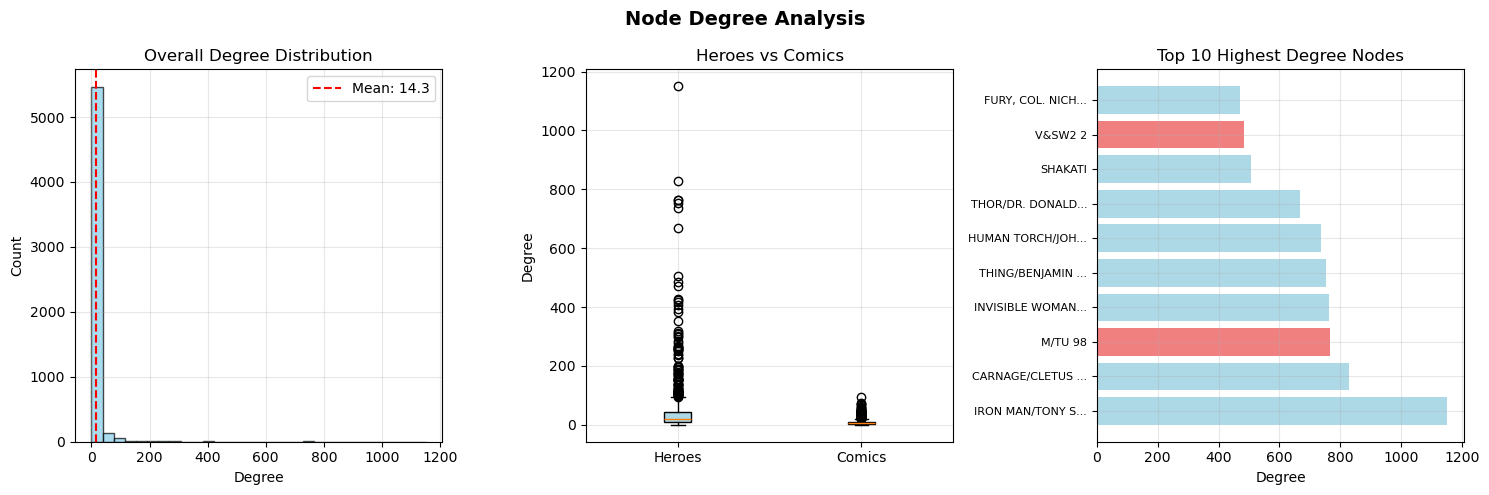

KEY INSIGHTS
Network Density: 0.002499 (0.2499%)
Average Degree - Heroes: 47.21, Comics: 8.43
Heroes tend to be more connected than comics
Network Hubs (top 5%): 290 nodes with degree ≥ 36


In [8]:
print("NODE DEGREE ANALYSIS")

import matplotlib.pyplot as plt
import numpy as np

def calculate_degrees(edge_index, num_nodes):
    if edge_index.is_cuda:
        edge_index = edge_index.cpu()
    
    degrees = torch.zeros(num_nodes, dtype=torch.long)
    for i in range(edge_index.shape[1]):
        node = edge_index[0, i].item()
        degrees[node] += 1
    return degrees.numpy()

def print_stats(degrees, label):
    print(f"\n{label}:")
    print(f"  Count: {len(degrees):,}")
    print(f"  Mean: {np.mean(degrees):.2f}")
    print(f"  Median: {np.median(degrees):.2f}")
    print(f"  Min: {np.min(degrees)}")
    print(f"  Max: {np.max(degrees)}")
    print(f"  Std Dev: {np.std(degrees):.2f}")

num_edges = data.edge_index.size(1) // 2
print(f"Graph: {data.num_nodes:,} nodes, {num_edges:,} edges")

degrees = calculate_degrees(data.edge_index, data.num_nodes)

hero_indices = nodes_df[nodes_df['type'] == 'hero']['node_idx'].values
comic_indices = nodes_df[nodes_df['type'] == 'comic']['node_idx'].values

max_idx = len(degrees) - 1
hero_indices = hero_indices[hero_indices <= max_idx]
comic_indices = comic_indices[comic_indices <= max_idx]

hero_degrees = degrees[hero_indices]
comic_degrees = degrees[comic_indices]

print_stats(degrees, "OVERALL")
print_stats(hero_degrees, "HEROES")
print_stats(comic_degrees, "COMICS")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Node Degree Analysis', fontsize=14, fontweight='bold')

axes[0].hist(degrees, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(np.mean(degrees), color='red', linestyle='--', label=f'Mean: {np.mean(degrees):.1f}')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Count')
axes[0].set_title('Overall Degree Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

data_for_box = [hero_degrees, comic_degrees]
box_plot = axes[1].boxplot(data_for_box, labels=['Heroes', 'Comics'], patch_artist=True)
colors = ['lightblue', 'lightcoral']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
axes[1].set_ylabel('Degree')
axes[1].set_title('Heroes vs Comics')
axes[1].grid(True, alpha=0.3)

top_n = 10
top_indices = np.argsort(degrees)[-top_n:][::-1]
top_degrees = degrees[top_indices]
top_names = [nodes_df.iloc[idx]['node'][:15] + '...' if len(nodes_df.iloc[idx]['node']) > 15 
             else nodes_df.iloc[idx]['node'] for idx in top_indices]
top_types = [nodes_df.iloc[idx]['type'] for idx in top_indices]

colors = ['lightblue' if t == 'hero' else 'lightcoral' for t in top_types]
axes[2].barh(range(top_n), top_degrees, color=colors)
axes[2].set_yticks(range(top_n))
axes[2].set_yticklabels(top_names, fontsize=8)
axes[2].set_xlabel('Degree')
axes[2].set_title(f'Top {top_n} Highest Degree Nodes')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("KEY INSIGHTS")

density = num_edges / (data.num_nodes * (data.num_nodes - 1) / 2)
print(f"Network Density: {density:.6f} ({density*100:.4f}%)")

hero_mean = np.mean(hero_degrees)
comic_mean = np.mean(comic_degrees)
print(f"Average Degree - Heroes: {hero_mean:.2f}, Comics: {comic_mean:.2f}")

if hero_mean > comic_mean * 1.1:
    print("Heroes tend to be more connected than comics")
elif comic_mean > hero_mean * 1.1:
    print("Comics tend to be more connected than heroes")
else:
    print("Heroes and comics have similar connectivity")

hub_threshold = np.percentile(degrees, 95)
num_hubs = np.sum(degrees >= hub_threshold)
print(f"Network Hubs (top 5%): {num_hubs} nodes with degree ≥ {hub_threshold:.0f}")

### 2.4 Subgraph Visualization ( Uncomment the end of the cell in case of use )

In [9]:
def create_networkx_graph(edge_index, nodes_df):
    if edge_index.is_cuda:
        edge_index = edge_index.cpu()
        
    G = nx.Graph()

    for idx, row in nodes_df.iterrows():
        node_id = row['node_idx']
        G.add_node(node_id, 
                  name=row['node'], 
                  type=row['type'])
    
    edge_list = edge_index.t().numpy()
    for i in range(0, len(edge_list), 2):  # Skip duplicate edges (undirected)
        u, v = edge_list[i]
        if not G.has_edge(u, v):
            G.add_edge(u, v)
    
    return G

def plot_subgraph(G, nodes_df, layout='spring', figsize=(15, 12)):    
    print(f"Creating visualization with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges...")
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Subgraph Visualization - Hero-Comic Network', fontsize=16, fontweight='bold')
    
    if layout == 'spring':
        pos = nx.spring_layout(G, k=1, iterations=50, seed=42)
    elif layout == 'circular':
        pos = nx.circular_layout(G)
    elif layout == 'kamada':
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = nx.spring_layout(G, seed=42)
    
    hero_nodes = [n for n in G.nodes() if G.nodes[n]['type'] == 'hero']
    comic_nodes = [n for n in G.nodes() if G.nodes[n]['type'] == 'comic']
    
    node_colors = []
    node_sizes = []
    degrees = dict(G.degree())
    
    for node in G.nodes():
        if G.nodes[node]['type'] == 'hero':
            node_colors.append('lightblue')
        else:
            node_colors.append('lightcoral')
        
        size = max(50, min(500, degrees[node] * 20))
        node_sizes.append(size)
    
    ax1 = axes[0, 0]
    nx.draw(G, pos, ax=ax1,
            node_color=node_colors,
            node_size=node_sizes,
            edge_color='gray',
            alpha=0.7,
            width=0.5)
    ax1.set_title(f'Full Subgraph\n({len(hero_nodes)} heroes, {len(comic_nodes)} comics)')
    
    legend_elements = [Patch(facecolor='lightblue', label='Heroes'),
                      Patch(facecolor='lightcoral', label='Comics')]
    ax1.legend(handles=legend_elements, loc='upper right')
    
    ax2 = axes[0, 1]
    degree_threshold = np.percentile(list(degrees.values()), 80)  # Top 20%
    high_degree_nodes = [n for n, d in degrees.items() if d >= degree_threshold]
    G_high = G.subgraph(high_degree_nodes)
    
    high_pos = {n: pos[n] for n in high_degree_nodes}
    high_colors = [node_colors[list(G.nodes()).index(n)] for n in high_degree_nodes]
    high_sizes = [node_sizes[list(G.nodes()).index(n)] for n in high_degree_nodes]
    
    nx.draw(G_high, high_pos, ax=ax2,
            node_color=high_colors,
            node_size=high_sizes,
            edge_color='darkgray',
            alpha=0.8,
            width=1.0)
    ax2.set_title(f'High-Degree Nodes\n(degree ≥ {degree_threshold:.0f})')
    
    ax3 = axes[1, 0]
    hero_degrees = [degrees[n] for n in hero_nodes]
    comic_degrees = [degrees[n] for n in comic_nodes]
    
    ax3.hist([hero_degrees, comic_degrees], bins=20, alpha=0.7, 
             label=['Heroes', 'Comics'], color=['lightblue', 'lightcoral'])
    ax3.set_xlabel('Degree')
    ax3.set_ylabel('Count')
    ax3.set_title('Degree Distribution by Type')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    ax4 = axes[1, 1]
    top_n = 15
    top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:top_n]
    top_node_ids = [n for n, d in top_nodes]
    
    G_top = G.subgraph(top_node_ids)
    top_pos = {n: pos[n] for n in top_node_ids}
    top_colors = [node_colors[list(G.nodes()).index(n)] for n in top_node_ids]
    
    nx.draw(G_top, top_pos, ax=ax4,
            node_color=top_colors,
            node_size=300,
            edge_color='darkgray',
            alpha=0.8,
            width=1.5)
    
    labels = {}
    for node_id in top_node_ids:
        name = G.nodes[node_id]['name']
        # Truncate long names
        if len(name) > 10:
            name = name[:10] + '...'
        labels[node_id] = name
    
    nx.draw_networkx_labels(G_top, top_pos, labels, ax=ax4, font_size=8)
    ax4.set_title(f'Top {top_n} Connected Nodes')
    
    plt.tight_layout()
    plt.show()
    
    return G, pos
"""
print("Converting to NetworkX format...")
G = create_networkx_graph(data.edge_index, nodes_df)

print(f"\nSubgraph Statistics:")
print(f"  Nodes: {G.number_of_nodes():,}")
print(f"  Edges: {G.number_of_edges():,}")
print(f"  Average Degree: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")
print(f"  Density: {nx.density(G):.6f}")

if nx.is_connected(G):
    print(f"  Graph is connected")
    print(f"  Diameter: {nx.diameter(G)}")
    print(f"  Average Path Length: {nx.average_shortest_path_length(G):.2f}")
else:
    components = list(nx.connected_components(G))
    print(f"  Graph has {len(components)} connected components")
    print(f"  Largest component: {len(max(components, key=len))} nodes")

# Plot the subgraph
print(f"\nGenerating visualization...")
G, pos = plot_subgraph(G, nodes_df, layout='spring')

# Network analysis
print(f"\n{'='*60}")
print("NETWORK ANALYSIS")
print(f"{'='*60}")

# Degree analysis
degrees = dict(G.degree())
hero_nodes = [n for n in G.nodes() if G.nodes[n]['type'] == 'hero']
comic_nodes = [n for n in G.nodes() if G.nodes[n]['type'] == 'comic']

hero_degrees = [degrees[n] for n in hero_nodes]
comic_degrees = [degrees[n] for n in comic_nodes]

print(f"Heroes: {len(hero_nodes)} nodes, avg degree: {np.mean(hero_degrees):.2f}")
print(f"Comics: {len(comic_nodes)} nodes, avg degree: {np.mean(comic_degrees):.2f}")

# Top connected nodes
print(f"\nTop 10 Most Connected Nodes:")
top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:10]
for i, (node_id, degree) in enumerate(top_nodes, 1):
    name = G.nodes[node_id]['name']
    node_type = G.nodes[node_id]['type']
    print(f"  {i:2d}. {name:25s} (degree: {degree:3d}, type: {node_type})")
"""

'\nprint("Converting to NetworkX format...")\nG = create_networkx_graph(data.edge_index, nodes_df)\n\nprint(f"\nSubgraph Statistics:")\nprint(f"  Nodes: {G.number_of_nodes():,}")\nprint(f"  Edges: {G.number_of_edges():,}")\nprint(f"  Average Degree: {2 * G.number_of_edges() / G.number_of_nodes():.2f}")\nprint(f"  Density: {nx.density(G):.6f}")\n\nif nx.is_connected(G):\n    print(f"  Graph is connected")\n    print(f"  Diameter: {nx.diameter(G)}")\n    print(f"  Average Path Length: {nx.average_shortest_path_length(G):.2f}")\nelse:\n    components = list(nx.connected_components(G))\n    print(f"  Graph has {len(components)} connected components")\n    print(f"  Largest component: {len(max(components, key=len))} nodes")\n\n# Plot the subgraph\nprint(f"\nGenerating visualization...")\nG, pos = plot_subgraph(G, nodes_df, layout=\'spring\')\n\n# Network analysis\nprint(f"\n{\'=\'*60}")\nprint("NETWORK ANALYSIS")\nprint(f"{\'=\'*60}")\n\n# Degree analysis\ndegrees = dict(G.degree())\nhero_n

## 3. PPR Computation using Andersen's Algorithm

We implement the efficient Personalized PageRank (PPR) computation using Andersen's algorithm as mentioned in the paper.

In [10]:
def compute_ppr_andersen(edge_index, alpha=0.15, eps=1e-5, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max().item() + 1

    print(f"Computing PPR matrix for {num_nodes} nodes using Andersen's algorithm...")
    print(f"This may take a while for large graphs. Please be patient.")
    start_time = time.time()

    edge_list = edge_index.t().cpu().numpy()
    adj = sp.coo_matrix(
        (np.ones(edge_list.shape[0]), (edge_list[:, 0], edge_list[:, 1])),
        shape=(num_nodes, num_nodes),
        dtype=np.float32
    )

    # Make the adjacency matrix symmetric (undirected)
    adj = adj + adj.T
    adj = adj.tocsr()

    rowsum = np.array(adj.sum(1))
    rowsum[rowsum == 0] = 1.0 
    d_inv = np.power(rowsum, -1).flatten()
    d_inv[np.isinf(d_inv)] = 0.0
    d_mat_inv = sp.diags(d_inv)
    norm_adj = d_mat_inv.dot(adj)

    ppr_matrix = np.zeros((num_nodes, num_nodes), dtype=np.float32)

    # Progress tracking variables
    last_update_time = time.time()
    update_interval = 5  # seconds

    # Compute PPR for each node using Andersen's algorithm
    for i in tqdm(range(num_nodes), desc="Computing PPR"):
        # Print progress update every few seconds
        current_time = time.time()
        if current_time - last_update_time > update_interval:
            elapsed = current_time - start_time
            progress = (i + 1) / num_nodes
            eta = elapsed / progress - elapsed if progress > 0 else 0
            #print(f"Progress: {progress*100:.1f}% ({i+1}/{num_nodes}), Elapsed: {elapsed:.1f}s, ETA: {eta:.1f}s")
            last_update_time = current_time

        r = np.zeros(num_nodes)
        p = np.zeros(num_nodes)
        r[i] = 1.0

        while np.max(r) > eps:
            j = np.argmax(r)
            p[j] += alpha * r[j]

            neighbors = norm_adj[j].nonzero()[1]
            if len(neighbors) > 0: 
                for k in neighbors:
                    r[k] += (1 - alpha) * r[j] * norm_adj[j, k] / len(neighbors)
                    
            r[j] = 0

        ppr_matrix[i] = p

    ppr_tensor = torch.FloatTensor(ppr_matrix)

    total_time = time.time() - start_time
    print(f"PPR matrix computation completed in {total_time:.2f} seconds!")
    return ppr_tensor

## 4. LPFormer Model Implementation

We implement the LPFormer model with all components as described in the paper, including GATv2 attention and order-invariant RPE.

In [11]:
class PPRThresholding(nn.Module):

    # This thresholds should change dynamically but in the paper dont explain how so we will use the init values from the paper
    def __init__(self, ppr_matrix, cn_threshold=1e-3, one_hop_threshold=1e-4, multi_hop_threshold=1e-5):
        super(PPRThresholding, self).__init__()
        self.ppr_matrix = ppr_matrix
        self.cn_threshold = cn_threshold
        self.one_hop_threshold = one_hop_threshold
        self.multi_hop_threshold = multi_hop_threshold
        self.last_selection_counts = {}
    
    def forward(self, src, dst):
        src_ppr = self.ppr_matrix[src]
        dst_ppr = self.ppr_matrix[dst]
        
        # Select nodes based on thresholds
        ## Common neighbors
        cn_mask = (src_ppr > self.cn_threshold) & (dst_ppr > self.cn_threshold)
        cn_nodes = torch.nonzero(cn_mask).squeeze(-1)
        if cn_nodes.dim() == 0 and cn_nodes.numel() > 0:
            cn_nodes = cn_nodes.unsqueeze(0)
        
        ## One-hop neighbors
        one_hop_mask = (src_ppr > self.one_hop_threshold) | (dst_ppr > self.one_hop_threshold)
        one_hop_mask = one_hop_mask & ~cn_mask  # Exclude CNs already counted
        one_hop_nodes = torch.nonzero(one_hop_mask).squeeze(-1)
        if one_hop_nodes.dim() == 0 and one_hop_nodes.numel() > 0:
            one_hop_nodes = one_hop_nodes.unsqueeze(0)
        
        ## Multi-hop neighbors
        multi_hop_mask = (src_ppr > self.multi_hop_threshold) | (dst_ppr > self.multi_hop_threshold)
        multi_hop_mask = multi_hop_mask & ~cn_mask & ~one_hop_mask  # Exclude already counted nodes
        multi_hop_nodes = torch.nonzero(multi_hop_mask).squeeze(-1)
        if multi_hop_nodes.dim() == 0 and multi_hop_nodes.numel() > 0:
            multi_hop_nodes = multi_hop_nodes.unsqueeze(0)
        
        self.last_selection_counts = {
            'cn': cn_nodes.numel(),
            'one_hop': one_hop_nodes.numel(),
            'multi_hop': multi_hop_nodes.numel()
        }
        
        selected_nodes = []
        if cn_nodes.numel() > 0:
            selected_nodes.append(cn_nodes)
        if one_hop_nodes.numel() > 0:
            selected_nodes.append(one_hop_nodes)
        if multi_hop_nodes.numel() > 0:
            selected_nodes.append(multi_hop_nodes)
        
        if selected_nodes:
            selected_nodes = torch.cat(selected_nodes)
        else:
            selected_nodes = torch.tensor([], device=self.ppr_matrix.device, dtype=torch.long)
        
        if src not in selected_nodes:
            selected_nodes = torch.cat([selected_nodes, torch.tensor([src], device=selected_nodes.device)])
        if dst not in selected_nodes:
            selected_nodes = torch.cat([selected_nodes, torch.tensor([dst], device=selected_nodes.device)])
        
        return selected_nodes

class PPRPositionalEncoding(nn.Module):
    def __init__(self, ppr_matrix, hidden_dim):
        super(PPRPositionalEncoding, self).__init__()
        self.ppr_matrix = ppr_matrix
        self.hidden_dim = hidden_dim
        self.projection = nn.Linear(2, hidden_dim)
    
    def forward(self, src, dst):
        # Get PPR scores between source and destination (bidirectional)
        src_to_dst = self.ppr_matrix[src, dst]
        dst_to_src = self.ppr_matrix[dst, src]
        
        # Combine scores in an order-invariant manner
        ppr_features = torch.tensor([src_to_dst, dst_to_src], device=self.ppr_matrix.device)
        
        pos_encoding = self.projection(ppr_features)
        
        return pos_encoding

class GATv2AttentionLayer(nn.Module):
    def __init__(self, in_dim, out_dim, num_heads, dropout=0.1):
        super(GATv2AttentionLayer, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_heads = num_heads
        self.dropout = dropout
        
        self.gat = GATv2Conv(
            in_channels=in_dim,
            out_channels=out_dim // num_heads,
            heads=num_heads,
            dropout=dropout,
            concat=True
        )
    
    def forward(self, x, edge_index):
        return self.gat(x, edge_index)

class LPFormer(nn.Module):
    def __init__(self, num_nodes, node_features, train_edge_index, edge_index, hidden_dim=128, num_layers=2, num_heads=4, dropout=0.1, ppr_threshold=1e-3):
        super(LPFormer, self).__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dropout = dropout
        self.device = node_features.device
        self.node_dim = node_features.shape[1]
        print(f"Node feature dimension: {self.node_dim}")

        print("Creating GCN layers for node representation...")
        self.convs = nn.ModuleList()
        self.convs.append(GCNConv(self.node_dim, hidden_dim))
        for i in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_dim, hidden_dim))
            print(f"  Added GCN layer {i+1} with hidden_dim {hidden_dim}")

        print("Computing PPR matrix using Andersen's algorithm...")
        ppr_tensor = compute_ppr_andersen(
            train_data.edge_index,
            alpha=0.15,
            eps=1e-5,
            num_nodes=num_nodes
        )

        ppr_tensor = ppr_tensor.to(self.device)
        self.register_buffer('ppr_matrix', ppr_tensor)
        print(f"PPR matrix shape: {ppr_tensor.shape}, device: {ppr_tensor.device}")

        print("Creating adjacency matrix...")
        edge_list = train_data.edge_index.t().cpu().numpy()
        adj = sp.coo_matrix(
            (np.ones(edge_list.shape[0]), (edge_list[:, 0], edge_list[:, 1])),
            shape=(num_nodes, num_nodes),
            dtype=np.float32
        )
        adj_tensor = torch.FloatTensor(adj.todense()).to(self.device)
        self.register_buffer('adj_matrix', adj_tensor)
        print(f"Adjacency matrix shape: {adj_tensor.shape}, device: {adj_tensor.device}")

        print("Creating PPR thresholding module...")
        cn_threshold = ppr_threshold
        one_hop_threshold = ppr_threshold / 10
        multi_hop_threshold = ppr_threshold / 100
        self.ppr_threshold = PPRThresholding(
            self.ppr_matrix,
            cn_threshold=cn_threshold,
            one_hop_threshold=one_hop_threshold,
            multi_hop_threshold=multi_hop_threshold
        )

        print("Creating PPR positional encoding module with order invariance...")
        self.ppr_pos_encoding = PPRPositionalEncoding(self.ppr_matrix, hidden_dim)

        print("Creating GATv2 attention layers...")
        self.attention_layers = nn.ModuleList()
        for i in range(num_layers):
            self.attention_layers.append(GATv2AttentionLayer(hidden_dim, hidden_dim, num_heads, dropout))
            print(f"  Added GATv2 attention layer {i+1}")

        print("Creating final prediction layer...")
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 2 + 3, hidden_dim),  # node product + pairwise + 3 counts
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        print("LPFormer model initialized successfully!")
        print("---\n")

    def forward(self, node_features, edge_index, target_links):
        node_features = node_features.to(self.device)
        edge_index = edge_index.to(self.device)
        target_links = target_links.to(self.device)

        total_cn_count = 0
        total_one_hop_count = 0
        total_multi_hop_count = 0
        total_nodes = 0
        
        x = node_features
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < len(self.convs) - 1: 
                x = F.relu(x)
    
        predictions = []
    
        #target_links_iter = tqdm(target_links, desc="Processing links", disable=len(target_links) < 100)
        target_links_iter = tqdm(target_links, desc="Processing links", disable=True)
    
        for link in target_links_iter:
            src, dst = link
    
            selected_nodes = self.ppr_threshold(src, dst)
            if hasattr(self.ppr_threshold, 'last_selection_counts'):
                total_cn_count += self.ppr_threshold.last_selection_counts.get('cn', 0)
                total_one_hop_count += self.ppr_threshold.last_selection_counts.get('one_hop', 0)
                total_multi_hop_count += self.ppr_threshold.last_selection_counts.get('multi_hop', 0)
                total_nodes += len(selected_nodes)
           
            # First, get neighbors of both source and destination
            src_neighbors = set(self.adj_matrix[src].nonzero(as_tuple=False).flatten().cpu().numpy())
            dst_neighbors = set(self.adj_matrix[dst].nonzero(as_tuple=False).flatten().cpu().numpy())
            
            # Categorize each selected node
            cn_count = 0
            one_hop_count = 0
            multi_hop_count = 0
            
            for node in selected_nodes.cpu().numpy():
                # Skip source and destination nodes
                if node == src.item() or node == dst.item():
                    continue
                    
                if node in src_neighbors and node in dst_neighbors:
                    cn_count += 1
                elif node in src_neighbors or node in dst_neighbors:
                    one_hop_count += 1
                else:
                    multi_hop_count += 1
            
            if link is target_links[0] or link is target_links[min(10, len(target_links)-1)] or link is target_links[min(100, len(target_links)-1)]:
                print(f"\nNode selection for link {src.item()}-{dst.item()}:")
                print(f"  Selected {len(selected_nodes)} nodes: {cn_count} CNs, {one_hop_count} 1-hops, {multi_hop_count} multi-hops")
                print(f"  Ratio: {cn_count/(cn_count+one_hop_count+multi_hop_count):.2%} CNs, {one_hop_count/(cn_count+one_hop_count+multi_hop_count):.2%} 1-hops, {multi_hop_count/(cn_count+one_hop_count+multi_hop_count):.2%} multi-hops")
            
            subgraph_x = x[selected_nodes]
    
            n = len(selected_nodes)
            rows, cols = [], []
            for a in range(n):
                for b in range(n):
                    if a != b:  # Exclude self-loops
                        rows.append(a)
                        cols.append(b)
            subgraph_edge_index = torch.tensor([rows, cols], dtype=torch.long, device=self.device)
    
            for attn_layer in self.attention_layers:
                subgraph_x = attn_layer(subgraph_x, subgraph_edge_index)
                subgraph_x = F.relu(subgraph_x)
                subgraph_x = F.dropout(subgraph_x, p=self.dropout, training=self.training)
    
            src_idx = (selected_nodes == src).nonzero().item()
            dst_idx = (selected_nodes == dst).nonzero().item()
    
            src_repr = subgraph_x[src_idx]
            dst_repr = subgraph_x[dst_idx]
    
            # Compute PPR-based positional encoding
            pos_encoding = self.ppr_pos_encoding(src, dst)
    
            # Compute LP factors
            ## Common neighbors count
            def get_common_neighbors(adj_matrix, src, dst):
                src_row = src.item()
                dst_row = dst.item()
                src_neighbors = adj_matrix[src_row].nonzero(as_tuple=False).flatten()
                dst_neighbors = adj_matrix[dst_row].nonzero(as_tuple=False).flatten()
                
                # Handle empty neighbor cases
                if src_neighbors.shape[0] == 0 or dst_neighbors.shape[0] == 0:
                    return torch.tensor(0, device=adj_matrix.device).float()
                
                # Convert to sets for intersection
                src_set = set(src_neighbors.cpu().numpy())
                dst_set = set(dst_neighbors.cpu().numpy())
                common_count = len(src_set.intersection(dst_set))
                
                return torch.tensor(common_count, device=adj_matrix.device).float()
            
            # Calculate common neighbors
            common_neighbors = get_common_neighbors(self.adj_matrix, src, dst)
            common_neighbors = common_neighbors / (self.num_nodes ** 0.5)  # Normalize
    
            ## PPR score
            src_ppr = self.ppr_matrix[src]
            dst_ppr = self.ppr_matrix[dst]
            ppr_sim = F.cosine_similarity(src_ppr.unsqueeze(0), dst_ppr.unsqueeze(0)).item()
            ppr_score = torch.tensor(ppr_sim, device=self.device)
            
            ## Feature similarity
            feat_sim = F.cosine_similarity(node_features[src].unsqueeze(0), node_features[dst].unsqueeze(0)).item()
            feat_sim = torch.tensor(feat_sim, device=self.device)
    
            # Combine node representations and LP factors
            combined_repr = torch.cat([
                src_repr * dst_repr,
                pos_encoding,
                common_neighbors.unsqueeze(0),
                ppr_score.unsqueeze(0),
                feat_sim.unsqueeze(0)
            ])
    
            pred = self.predictor(combined_repr)
            predictions.append(pred)

        return torch.cat(predictions)

## 5. Evaluation Metrics

We implement the evaluation metrics used in the paper, including Mean Reciprocal Rank (MRR), AUC, and Average Precision (AP).

In [12]:
class MRREvaluator:
    def __init__(self):
        pass
    
    def eval(self, input_dict):
        y_pred_pos = input_dict['y_pred_pos']
        y_pred_neg = input_dict['y_pred_neg']

        # Compute MRR
        mrr_list = []
        
        for i, pos_score in enumerate(y_pred_pos):
            if isinstance(y_pred_neg, list):
                if i < len(y_pred_neg):
                    neg_scores = y_pred_neg[i]
                else:
                    print(f"Warning: Not enough negative scores for positive example {i}")
                    continue
            else:
                # Assume y_pred_neg is a tensor with all negatives
                batch_size = y_pred_neg.shape[0] // y_pred_pos.shape[0]
                start_idx = i * batch_size
                end_idx = min((i + 1) * batch_size, y_pred_neg.shape[0])
                neg_scores = y_pred_neg[start_idx:end_idx]

            all_scores = torch.cat([pos_score.view(1), neg_scores])
            
            sorted_indices = torch.argsort(all_scores, descending=True)
            
            rank = (sorted_indices == 0).nonzero().item() + 1
            
            # Compute reciprocal rank
            mrr_list.append(1.0 / rank)
        
        return torch.tensor(mrr_list).mean().item()

## 6. Training, Evaluation and Test Functions

We implement the training and evaluation functions for the LPFormer model.

### 6.1 Train

In [13]:
def train(model, optimizer, scheduler, data, split_edge, batch_size=1024):
    model.train()
    device = model.device
    
    print("Training model...")
    start_time = time.time()
    
    train_edge = split_edge['train']['edge'].to(device)
    train_edge_neg = split_edge['train']['edge_neg'].to(device)
    
    train_edge_all = torch.cat([train_edge, train_edge_neg], dim=0)
    train_label_all = torch.cat([torch.ones(train_edge.size(0)), torch.zeros(train_edge_neg.size(0))], dim=0).to(device)
    
    perm = torch.randperm(train_edge_all.size(0))
    train_edge_all = train_edge_all[perm]
    train_label_all = train_label_all[perm]
    
    total_loss = 0
    num_batches = (train_edge_all.size(0) + batch_size - 1) // batch_size
    
    for batch_idx in tqdm(range(num_batches), desc="Training batches"):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, train_edge_all.size(0))
        batch_edge = train_edge_all[start_idx:end_idx]
        batch_label = train_label_all[start_idx:end_idx]
        
        optimizer.zero_grad()
        
        pred = model(data.x, train_data.edge_index, batch_edge)
        loss = F.binary_cross_entropy(pred, batch_label)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_edge.size(0)
    
    if scheduler is not None:
        scheduler.step()
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    return total_loss / train_edge_all.size(0)

### 6.2 Validation and Test

In [14]:
@torch.no_grad()
def test(model, data, split_edge, evaluator, batch_size=1024):
    model.eval()
    device = model.device
    
    print("Evaluating model...")
    start_time = time.time()
    
    # Evaluate on validation set
    print("Evaluating on validation set...")
    pos_valid_edge = split_edge['valid']['edge'].to(device)
    neg_valid_edge = split_edge['valid']['edge_neg'].to(device)
    
    pos_valid_preds = []
    for perm in DataLoader(range(pos_valid_edge.size(0)), batch_size):
        edge = pos_valid_edge[perm]
        pos_valid_preds.append(model(data.x, data.edge_index, edge).cpu())
    pos_valid_pred = torch.cat(pos_valid_preds, dim=0)
    
    neg_valid_preds = []
    for perm in DataLoader(range(neg_valid_edge.size(0)), batch_size):
        edge = neg_valid_edge[perm]
        neg_valid_preds.append(model(data.x, data.edge_index, edge).cpu())
    neg_valid_pred = torch.cat(neg_valid_preds, dim=0)
    
    print("Evaluating on test set...")
    pos_test_edge = split_edge['test']['edge'].to(device)
    neg_test_edge = split_edge['test']['edge_neg'].to(device)
    
    pos_test_preds = []
    for perm in DataLoader(range(pos_test_edge.size(0)), batch_size):
        edge = pos_test_edge[perm]
        pos_test_preds.append(model(data.x, data.edge_index, edge).cpu())
    pos_test_pred = torch.cat(pos_test_preds, dim=0)
    
    neg_test_preds = []
    for perm in DataLoader(range(neg_test_edge.size(0)), batch_size):
        edge = neg_test_edge[perm]
        neg_test_preds.append(model(data.x, data.edge_index, edge).cpu())
    neg_test_pred = torch.cat(neg_test_preds, dim=0)
    
    print("Computing evaluation metrics...")
    results = {}
    
    # Prepare data for MRR evaluation
    valid_mrr_data = {
        'y_pred_pos': pos_valid_pred,
        'y_pred_neg': []
    }
    
    neg_per_pos = neg_valid_edge.size(0) // pos_valid_edge.size(0)
    for i in range(pos_valid_edge.size(0)):
        start_idx = i * neg_per_pos
        end_idx = start_idx + neg_per_pos
        # Handle the case where division isn't perfect
        if i == pos_valid_edge.size(0) - 1:
            end_idx = neg_valid_edge.size(0)
        valid_mrr_data['y_pred_neg'].append(neg_valid_pred[start_idx:end_idx])
    
    test_mrr_data = {
        'y_pred_pos': pos_test_pred,
        'y_pred_neg': []
    }
    
    neg_per_pos = neg_test_edge.size(0) // pos_test_edge.size(0)
    for i in range(pos_test_edge.size(0)):
        start_idx = i * neg_per_pos
        end_idx = start_idx + neg_per_pos
        # Handle the case where division isn't perfect
        if i == pos_test_edge.size(0) - 1:
            end_idx = neg_test_edge.size(0)
        test_mrr_data['y_pred_neg'].append(neg_test_pred[start_idx:end_idx])
    
    # Compute MRR
    valid_mrr = evaluator.eval(valid_mrr_data)
    test_mrr = evaluator.eval(test_mrr_data)
    
    # Compute AUC and AP
    from sklearn.metrics import roc_auc_score, average_precision_score
    
    valid_labels = torch.cat([torch.ones(pos_valid_pred.size(0)), torch.zeros(neg_valid_pred.size(0))]).numpy()
    valid_preds = torch.cat([pos_valid_pred, neg_valid_pred]).numpy()
    valid_auc = roc_auc_score(valid_labels, valid_preds)
    valid_ap = average_precision_score(valid_labels, valid_preds)
    
    test_labels = torch.cat([torch.ones(pos_test_pred.size(0)), torch.zeros(neg_test_pred.size(0))]).numpy()
    test_preds = torch.cat([pos_test_pred, neg_test_pred]).numpy()
    test_auc = roc_auc_score(test_labels, test_preds)
    test_ap = average_precision_score(test_labels, test_preds)
    
    results['valid'] = valid_mrr
    results['test'] = test_mrr
    results['valid_auc'] = valid_auc
    results['test_auc'] = test_auc
    results['valid_ap'] = valid_ap
    results['test_ap'] = test_ap
    
    evaluation_time = time.time() - start_time
    print(f"Evaluation completed in {evaluation_time:.2f} seconds")
    
    return results

In [15]:
@torch.no_grad()
def analyze_lp_factors(model, data, split_edge, percentile=90):
    model.eval()
    device = model.device
    
    print("Analyzing LP factors...")
    start_time = time.time()
    
    pos_test_edge = split_edge['test']['edge'].to(device)
    
    def get_neighbors(node_idx):
        neighbors = model.adj_matrix[node_idx].nonzero(as_tuple=False).flatten()
        return set(neighbors.cpu().numpy()) if neighbors.numel() > 0 else set()
    
    # Compute LP factors for each edge
    # Common neighbors
    print("Computing common neighbor scores...")
    cn_scores = []
    for edge in tqdm(pos_test_edge, desc="Computing CN scores"):
        a, b = edge[0].item(), edge[1].item()
        a_neighbors = get_neighbors(a)
        b_neighbors = get_neighbors(b)
        cn_score = len(a_neighbors & b_neighbors)
        cn_scores.append(cn_score)
    cn_scores = torch.tensor(cn_scores, device=device).float()  # Convert to float
    
    # PPR
    print("Computing PPR scores...")
    ppr_scores = []
    for edge in tqdm(pos_test_edge, desc="Computing PPR scores"):
        a, b = edge[0].item(), edge[1].item()
        
        # Use cosine similarity of PPR vectors for a more robust score
        src_ppr = model.ppr_matrix[a]
        dst_ppr = model.ppr_matrix[b]
        ppr_sim = F.cosine_similarity(src_ppr.unsqueeze(0), dst_ppr.unsqueeze(0)).item()
        ppr_scores.append(ppr_sim)
    ppr_scores = torch.tensor(ppr_scores, device=device).float()  # Convert to float
    
    # Cosine similarity
    print("Computing feature similarity scores...")
    feat_scores = []
    for edge in tqdm(pos_test_edge, desc="Computing feature similarity scores"):
        a, b = edge[0].item(), edge[1].item()
        feat_a = data.x[a]
        feat_b = data.x[b]
        feat_sim = F.cosine_similarity(feat_a.unsqueeze(0), feat_b.unsqueeze(0)).item()
        feat_scores.append(feat_sim)
    feat_scores = torch.tensor(feat_scores, device=device).float()  # Convert to float

    # Values from the paper
    cn_threshold = torch.quantile(cn_scores, 0.75)  # 75th percentile for CN
    ppr_threshold = torch.quantile(ppr_scores, 0.85)  # 85th percentile for PPR
    feat_threshold = torch.quantile(feat_scores, 0.75)  # 75th percentile for features
    
    print(f"Adjusted percentile thresholds:")
    print(f"  CN (75th): {cn_threshold:.4f}")
    print(f"  PPR (85th): {ppr_threshold:.4f}")
    print(f"  Feature (75th): {feat_threshold:.4f}")
    
    print("\nScore distributions:")
    def print_histogram(scores, name, bins=5):
        import numpy as np
        counts, bin_edges = np.histogram(scores.cpu().numpy(), bins=bins)
        max_count = max(counts)
        bar_length = 30 
        
        print(f"\n{name} distribution:")
        for i in range(len(counts)):
            bar = "#" * int(counts[i] / max_count * bar_length)
            print(f"  [{bin_edges[i]:.4f}, {bin_edges[i+1]:.4f}): {counts[i]:5d} {bar}")
    
    print_histogram(cn_scores, "Common Neighbors")
    print_histogram(ppr_scores, "PPR")
    print_histogram(feat_scores, "Feature Similarity")
    
    print("\nCategorizing edges by dominant factor...")
    local_edges = []
    global_edges = []
    feature_edges = []
    
    for i, edge in enumerate(pos_test_edge):
        # Calculate relative strength of each factor compared to its threshold
        epsilon = 1e-6
        rel_local = cn_scores[i] / (cn_threshold + epsilon) if cn_threshold > 0 else 0
        rel_global = ppr_scores[i] / (ppr_threshold + epsilon)
        rel_feature = feat_scores[i] / (feat_threshold + epsilon)
        
        # Find dominant factor
        rel_scores = [rel_local, rel_global, rel_feature]
        max_rel = max(rel_scores)
        dominant_idx = rel_scores.index(max_rel)
        
        # Only categorize if the dominant factor exceeds its threshold
        if max_rel >= 1.0:
            if dominant_idx == 0:
                local_edges.append(i)
            elif dominant_idx == 1:
                global_edges.append(i)
            elif dominant_idx == 2:
                feature_edges.append(i)
    
    local_edges = torch.tensor(local_edges, device=device)
    global_edges = torch.tensor(global_edges, device=device)
    feature_edges = torch.tensor(feature_edges, device=device)
    
    print(f"Edges categorized by dominant factor:")
    print(f"  Local: {len(local_edges)}")
    print(f"  Global: {len(global_edges)}")
    print(f"  Feature: {len(feature_edges)}")
    print(f"  Total categorized: {len(local_edges) + len(global_edges) + len(feature_edges)}")
    print(f"  Total test edges: {len(pos_test_edge)}")
    
    print("Evaluating model performance by factor type...")
    results = {}
    
    with torch.no_grad():
        if len(local_edges) > 0:
            print("Evaluating on local factor edges...")
            local_pred = model(data.x, data.edge_index, pos_test_edge[local_edges])
            results['local'] = local_pred.mean().item()
        else:
            results['local'] = float('nan')
        
        if len(global_edges) > 0:
            print("Evaluating on global factor edges...")
            global_pred = model(data.x, data.edge_index, pos_test_edge[global_edges])
            results['global'] = global_pred.mean().item()
        else:
            results['global'] = float('nan')
        
        if len(feature_edges) > 0:
            print("Evaluating on feature factor edges...")
            feature_pred = model(data.x, data.edge_index, pos_test_edge[feature_edges])
            results['feature'] = feature_pred.mean().item()
        else:
            results['feature'] = float('nan')
    
    analysis_time = time.time() - start_time
    print(f"LP factor analysis completed in {analysis_time:.2f} seconds")
    
    return results

## 7. Model Training and Evaluation

We train and evaluate the LPFormer model on the Marvel dataset.

In [16]:
evaluator = MRREvaluator()

hyperparams = {
    'hidden_dim': 128,
    'learning_rate': 1e-3,
    'decay': 0.95,
    'dropout': 0.3,
    'weight_decay': 1e-4,
    'ppr_threshold': 1e-3
}

print(f"\nUsing hyperparameters:")
for key, value in hyperparams.items():
    print(f"  {key}: {value}")

data = data.to(device)


Using hyperparameters:
  hidden_dim: 128
  learning_rate: 0.001
  decay: 0.95
  dropout: 0.3
  weight_decay: 0.0001
  ppr_threshold: 0.001


### 7.1 Init model

In [17]:
print("Initializing LPFormer model...")
start_time = time.time()

model = LPFormer(
    num_nodes=data.num_nodes,
    node_features=data.x,
    train_edge_index=train_data.edge_index,
    edge_index=data.edge_index,
    hidden_dim=hyperparams['hidden_dim'],
    num_layers=2,
    num_heads=4,
    dropout=hyperparams['dropout'],
    ppr_threshold=hyperparams['ppr_threshold']
).to(device)

print("Initializing optimizer and scheduler...")
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=hyperparams['learning_rate'],
    weight_decay=hyperparams['weight_decay']
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma=hyperparams['decay']
)

initialization_time = time.time() - start_time
print(f"Model initialization completed in {initialization_time:.2f} seconds")

Initializing LPFormer model...
Node feature dimension: 3
Creating GCN layers for node representation...
  Added GCN layer 1 with hidden_dim 128
Computing PPR matrix using Andersen's algorithm...
Computing PPR matrix for 5727 nodes using Andersen's algorithm...
This may take a while for large graphs. Please be patient.


Computing PPR:   0%|          | 0/5727 [00:00<?, ?it/s]

KeyboardInterrupt: 

### 7.2 Training

In [ ]:
best_val_metric = 0
final_test_metric = 0
num_epochs = 5  # Change
patience = 5
counter = 0

train_losses = []
val_metrics = []
test_metrics = []
val_aucs = []
test_aucs = []
val_aps = []
test_aps = []
epochs = []

print(f"Training LPFormer on Marvel dataset for {num_epochs} epochs...")
overall_start_time = time.time()

for epoch in range(1, num_epochs + 1):
    print(f"\n{'-'*50}")
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"{'-'*50}")
    epoch_start_time = time.time()
    
    # Train
    loss = train(model, optimizer, scheduler, data, split_edge)
    train_losses.append(loss)
    
    # Evaluate
    results = test(model, data, split_edge, evaluator)
    val_metric = results['valid']
    test_metric = results['test']
    val_metrics.append(val_metric)
    test_metrics.append(test_metric)
    val_aucs.append(results['valid_auc'])
    test_aucs.append(results['test_auc'])
    val_aps.append(results['valid_ap'])
    test_aps.append(results['test_ap'])
    epochs.append(epoch)
    
    epoch_time = time.time() - epoch_start_time
    print(f"\nEpoch {epoch:02d} completed in {epoch_time:.2f} seconds")
    print(f"Loss = {loss:.4f}")
    print(f"Validation: MRR = {val_metric:.4f}, AUC = {results['valid_auc']:.4f}, AP = {results['valid_ap']:.4f}")
    print(f"Test: MRR = {test_metric:.4f}, AUC = {results['test_auc']:.4f}, AP = {results['test_ap']:.4f}")
    
    if val_metric > best_val_metric:
        best_val_metric = val_metric
        final_test_metric = test_metric
        counter = 0
        print("New best model! Saving model state...")
        torch.save(model.state_dict(), f"lpformer_marvel_best.pt")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping after {epoch} epochs!")
            break

total_training_time = time.time() - overall_start_time
print(f"Training completed in {total_training_time:.2f} seconds!")
print(f"Best validation MRR: {best_val_metric:.4f}")
print(f"Final test MRR: {final_test_metric:.4f}")


### 7.3 Plot Results

In [ ]:
print("Plotting training curves...")
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs, val_metrics, label='Validation MRR')
plt.plot(epochs, test_metrics, label='Test MRR')
plt.title('MRR Metrics')
plt.xlabel('Epoch')
plt.ylabel('MRR')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs, val_aucs, label='Validation AUC')
plt.plot(epochs, test_aucs, label='Test AUC')
plt.title('AUC Metrics')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 7.4 Save results

In [ ]:
print("\nSaving experiment results...")

initialization_time = time.time() - start_time_project

experiment_data = {
    'num_nodes': data.num_nodes,
    'num_edges': data.edge_index.size(1) // 2,
    'running_time_seconds': round(initialization_time, 3) if initialization_time is not None else None,
    'final_train_loss': round(train_losses[-1], 3) if train_losses else None,
    'best_val_mrr': round(max(val_metrics), 3) if val_metrics else None,
    'best_test_mrr': round(max(test_metrics), 3) if test_metrics else None,
    'final_val_mrr': round(val_metrics[-1], 3) if val_metrics else None,
    'final_test_mrr': round(test_metrics[-1], 3) if test_metrics else None,
    'best_val_auc': round(max(val_aucs), 3) if val_aucs else None,
    'best_test_auc': round(max(test_aucs), 3) if test_aucs else None,
    'final_val_auc': round(val_aucs[-1], 3) if val_aucs else None,
    'final_test_auc': round(test_aucs[-1], 3) if test_aucs else None,
    'total_epochs': len(epochs) if epochs else None,
    'graph_density': round((data.edge_index.size(1) // 2) / (data.num_nodes * (data.num_nodes - 1) / 2), 3),
    'avg_degree': round((data.edge_index.size(1) / data.num_nodes), 3) if data.num_nodes > 0 else None
}

results_df = pd.DataFrame([experiment_data])

results_file = 'experiment_results.csv'

if os.path.exists(results_file):
    existing_df = pd.read_csv(results_file)
    
    duplicate_exists = False
    if len(existing_df) > 0:
        for idx, row in existing_df.iterrows():
            if (row['num_nodes'] == experiment_data['num_nodes'] and 
                row['num_edges'] == experiment_data['num_edges'] and
                abs(row.get('best_test_mrr', 0) - experiment_data.get('best_test_mrr', 0)) < 0.001):
                duplicate_exists = True
                print(f"Duplicate experiment detected (row {idx+1}). Skipping save.")
                break
    
    if not duplicate_exists:
        combined_df = pd.concat([existing_df, results_df], ignore_index=True)
        combined_df.to_csv(results_file, index=False)
        print(f"Results appended to {results_file}")
        print(f"Total experiments recorded: {len(combined_df)}")
    else:
        print("Experiment already exists in results file.")
else:
    results_df.to_csv(results_file, index=False)
    print(f"Results saved to new file: {results_file}")

if not duplicate_exists if 'duplicate_exists' in locals() else True:
    print(f"\n{'='*60}")
    print("CURRENT EXPERIMENT SUMMARY")
    print(f"{'='*60}")
    print(f"Graph Size: {experiment_data['num_nodes']:,} nodes, {experiment_data['num_edges']:,} edges")
    print(f"Density: {experiment_data['graph_density']:.6f}")
    print(f"Average Degree: {experiment_data['avg_degree']:.2f}")

    if experiment_data['running_time_seconds']:
        print(f"Running Time: {experiment_data['running_time_seconds']:.2f} seconds")

    if experiment_data['final_val_mrr']:
        print(f"Final Validation MRR: {experiment_data['final_val_mrr']:.4f}")
        print(f"Best Validation MRR: {experiment_data['best_val_mrr']:.4f}")

    if experiment_data['final_test_mrr']:
        print(f"Final Test MRR: {experiment_data['final_test_mrr']:.4f}")
        print(f"Best Test MRR: {experiment_data['best_test_mrr']:.4f}")

    if experiment_data['final_val_auc']:
        print(f"Final Validation AUC: {experiment_data['final_val_auc']:.4f}")
        print(f"Best Validation AUC: {experiment_data['best_val_auc']:.4f}")

    if experiment_data['final_test_auc']:
        print(f"Final Test AUC: {experiment_data['final_test_auc']:.4f}")
        print(f"Best Test AUC: {experiment_data['best_test_auc']:.4f}")

    print(f"Total Epochs: {experiment_data['total_epochs']}")

    if os.path.exists(results_file):
        all_results = pd.read_csv(results_file)
        
        if len(all_results) > 1:
            print(f"\n{'='*60}")
            print(f"EXPERIMENT COMPARISON")
            print(f"{'='*60}")
            
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            fig.suptitle('Experiment Results Comparison', fontsize=16, fontweight='bold')
            
            if 'best_test_mrr' in all_results.columns:
                ax1 = axes[0, 0]
                ax1.scatter(all_results['num_nodes'], all_results['best_test_mrr'], 
                           c='blue', alpha=0.7, s=50)
                ax1.set_xlabel('Number of Nodes')
                ax1.set_ylabel('Best Test MRR')
                ax1.set_title('Graph Size vs Performance (MRR)')
                ax1.grid(True, alpha=0.3)
                
                current_idx = len(all_results) - 1
                ax1.scatter(all_results.iloc[current_idx]['num_nodes'], 
                           all_results.iloc[current_idx]['best_test_mrr'],
                           c='red', s=100, marker='*', label='Current')
                ax1.legend()
            
            if 'best_test_auc' in all_results.columns:
                ax2 = axes[0, 1]
                ax2.scatter(all_results['num_nodes'], all_results['best_test_auc'], 
                           c='green', alpha=0.7, s=50)
                ax2.set_xlabel('Number of Nodes')
                ax2.set_ylabel('Best Test AUC')
                ax2.set_title('Graph Size vs Performance (AUC)')
                ax2.grid(True, alpha=0.3)
                
                ax2.scatter(all_results.iloc[current_idx]['num_nodes'], 
                           all_results.iloc[current_idx]['best_test_auc'],
                           c='red', s=100, marker='*', label='Current')
                ax2.legend()
            
            if 'running_time_seconds' in all_results.columns:
                ax3 = axes[1, 0]
                valid_times = all_results.dropna(subset=['running_time_seconds'])
                if len(valid_times) > 0:
                    ax3.scatter(valid_times['num_nodes'], valid_times['running_time_seconds'], 
                               c='orange', alpha=0.7, s=50)
                    ax3.set_xlabel('Number of Nodes')
                    ax3.set_ylabel('Running Time (seconds)')
                    ax3.set_title('Graph Size vs Running Time')
                    ax3.grid(True, alpha=0.3)
                    
                    if experiment_data['running_time_seconds']:
                        ax3.scatter(experiment_data['num_nodes'], 
                                   experiment_data['running_time_seconds'],
                                   c='red', s=100, marker='*', label='Current')
                        ax3.legend()
            
            if 'best_test_mrr' in all_results.columns:
                ax4 = axes[1, 1]
                ax4.scatter(all_results['graph_density'], all_results['best_test_mrr'], 
                           c='purple', alpha=0.7, s=50)
                ax4.set_xlabel('Graph Density')
                ax4.set_ylabel('Best Test MRR')
                ax4.set_title('Density vs Performance')
                ax4.grid(True, alpha=0.3)
                
                ax4.scatter(all_results.iloc[current_idx]['graph_density'], 
                           all_results.iloc[current_idx]['best_test_mrr'],
                           c='red', s=100, marker='*', label='Current')
                ax4.legend()
            
            plt.tight_layout()
            plt.show()
            
            print(f"\nSummary across {len(all_results)} experiments:")
            print(f"  Node range: {all_results['num_nodes'].min():,} - {all_results['num_nodes'].max():,}")
            print(f"  Edge range: {all_results['num_edges'].min():,} - {all_results['num_edges'].max():,}")
            
            if 'best_test_mrr' in all_results.columns:
                print(f"  Best Test MRR range: {all_results['best_test_mrr'].min():.4f} - {all_results['best_test_mrr'].max():.4f}")
            
            if 'best_test_auc' in all_results.columns:
                print(f"  Best Test AUC range: {all_results['best_test_auc'].min():.4f} - {all_results['best_test_auc'].max():.4f}")

print(f"\nExperiment logging complete!")
print(f"  File location: {os.path.abspath(results_file)}")

## 8. LP Factor Analysis

We analyze the model's performance on different types of LP factors.

In [ ]:
# Load best model
print("\nPerforming LP factor analysis...")
try:
    model.load_state_dict(torch.load(f"lpformer_marvel_best.pt"))
    print("Loaded best model for analysis")
except:
    print("Using current model for analysis (best model not found)")

# Analyze LP factors
factor_results = analyze_lp_factors(model, data, split_edge)

print("\nLP Factor Analysis Results:")
for factor, score in factor_results.items():
    print(f"  {factor.capitalize()} factor: {score:.4f}")

print("Plotting factor analysis results...")
plt.figure(figsize=(8, 5))
factors = list(factor_results.keys())
scores = [factor_results[f] for f in factors]

plt.bar(factors, scores)
plt.title('Performance by LP Factor Type')
plt.ylabel('Score')
plt.ylim(0, 1)

for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f"{score:.4f}", ha='center')

plt.tight_layout()
plt.show()

## 9. Example Link Predictions

We demonstrate the model's predictions on specific examples from the dataset.

In [ ]:
@torch.no_grad()
def predict_top_links(model, data, node_idx, k=10, existing_edges=None, node_type_map=None):
    model.eval()
    device = model.device
    
    source_type = node_type_map[node_idx]
    
    if source_type == 'hero':
        candidate_nodes = [idx for idx, node_type in node_type_map.items() 
                          if node_type == 'comic']
    else:
        candidate_nodes = [idx for idx, node_type in node_type_map.items() 
                          if node_type == 'hero']
    
    candidate_nodes = torch.tensor(candidate_nodes, device=device)
    
    candidate_links = torch.stack([
        torch.ones_like(candidate_nodes) * node_idx,
        candidate_nodes
    ], dim=1)
    
    if existing_edges is not None:
        existing_set = set()
        for i in range(existing_edges.size(0)):
            src, dst = existing_edges[i]
            existing_set.add((src.item(), dst.item()))
            existing_set.add((dst.item(), src.item()))  # Undirected graph
        
        filtered_links = []
        for i in range(candidate_links.size(0)):
            src, dst = candidate_links[i]
            if (src.item(), dst.item()) not in existing_set:
                filtered_links.append(candidate_links[i])
        
        if len(filtered_links) > 0:
            candidate_links = torch.stack(filtered_links)
    
    batch_size = 64
    all_scores = []
    
    for i in range(0, candidate_links.size(0), batch_size):
        batch_links = candidate_links[i:i+batch_size]
        batch_scores = model(data.x, data.edge_index, batch_links)
        all_scores.append(batch_scores)
    
    if len(all_scores) > 0:
        all_scores = torch.cat(all_scores)
        
        if all_scores.size(0) > k:
            top_k_values, top_k_indices = torch.topk(all_scores, k)
            top_k_links = candidate_links[top_k_indices]
            return top_k_links[:, 1], top_k_values
        else:
            return candidate_links[:, 1], all_scores
    else:
        return torch.tensor([], device=device), torch.tensor([], device=device)
def get_node_name(idx, nodes_df, idx_to_node):
    node_id = idx_to_node[idx]
    node_type = nodes_df[nodes_df['node'] == node_id]['type'].values[0]
    return f"{node_id} ({node_type})"

print("\nGenerating example link predictions...")
try:
    model.load_state_dict(torch.load(f"lpformer_marvel_best.pt"))
    print("Loaded best model for predictions")
except:
    print("Using current model for predictions (best model not found)")

existing_edges = data.edge_index.t()

hero_indices = nodes_df[nodes_df['type'] == 'hero']['node_idx'].values
comic_indices = nodes_df[nodes_df['type'] == 'comic']['node_idx'].values

np.random.seed(42)  # For reproducibility
example_heroes = np.random.choice(hero_indices, 3)
example_comics = np.random.choice(comic_indices, 3)
example_nodes = np.concatenate([example_heroes, example_comics])

for node_idx in example_nodes:
    node_name = get_node_name(node_idx, nodes_df, idx_to_node)
    print(f"\nTop 5 predicted links for {node_name}:")
    
    target_nodes, scores = predict_top_links(
        model, data, node_idx, k=5, 
        existing_edges=existing_edges,
        node_type_map=node_type_map  # Add this parameter
    )
    if len(target_nodes) > 0:
        for i, (target, score) in enumerate(zip(target_nodes, scores)):
            target_name = get_node_name(target.item(), nodes_df, idx_to_node)
            print(f"  {i+1}. {target_name} (Score: {score.item():.4f})")
    else:
        print("  No predictions available (all nodes are already connected)")

In [ ]:
def create_node_type_map(nodes_df, idx_to_node):
    node_type_map = {}
    for idx, node_name in idx_to_node.items():
        node_row = nodes_df[nodes_df['node'] == node_name]
        if not node_row.empty:
            node_type_map[idx] = node_row['type'].iloc[0]
        else:
            node_type_map[idx] = 'hero' if 'hero' in node_name.lower() else 'comic'
    return node_type_map

node_type_map = create_node_type_map(nodes_df, idx_to_node)

# Fixed visualize_predictions function
def visualize_predictions(model, data, node_idx, k=5, existing_edges=None, node_type_map=None):
    target_nodes, scores = predict_top_links(
        model, data, node_idx, k=k, existing_edges=existing_edges, node_type_map=node_type_map
    )
    
    if len(target_nodes) == 0:
        print("No predictions available for visualization")
        return
    
    G = nx.Graph()
    
    source_name = get_node_name(node_idx, nodes_df, idx_to_node)
    source_type = node_type_map[node_idx] if node_type_map else ('hero' if 'hero' in source_name.lower() else 'comic')
    G.add_node(source_name, type=source_type)
    
    for target, score in zip(target_nodes, scores):
        target_name = get_node_name(target.item(), nodes_df, idx_to_node)
        target_type = node_type_map[target.item()] if node_type_map else ('hero' if 'hero' in target_name.lower() else 'comic')
        G.add_node(target_name, type=target_type)
        G.add_edge(source_name, target_name, weight=score.item())
    
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G, seed=42, k=2, iterations=50)  # Better layout
    
    hero_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'hero']
    comic_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'comic']
    
    if hero_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=hero_nodes, node_color='skyblue', 
                              node_size=500, alpha=0.8, label='Heroes')
    
    if comic_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=comic_nodes, node_color='lightgreen', 
                              node_size=500, alpha=0.8, label='Comics')
    
    nx.draw_networkx_nodes(G, pos, nodelist=[source_name], node_color='red', 
                          node_size=700, alpha=1.0, label='Source')
    
    edge_widths = [d['weight']*5 for u, v, d in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7, edge_color='gray')
    
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')
    
    edge_labels = {(u, v): f"{d['weight']:.3f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    
    plt.title(f"Top {k} Predicted Links for {source_name}", fontsize=14, fontweight='bold')
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nVisualizing predictions for a hero:")
hero_idx = example_heroes[0]
visualize_predictions(model, data, hero_idx, k=5, existing_edges=existing_edges, node_type_map=node_type_map)

print("\nVisualizing predictions for a comic:")
comic_idx = example_comics[0] 
visualize_predictions(model, data, comic_idx, k=5, existing_edges=existing_edges, node_type_map=node_type_map)
